# 1 Import Libraries and Packages 

In [1]:
#Import the libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from datetime import datetime, timedelta, date
from prophet import Prophet
from neuralprophet import NeuralProphet
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.exponential_smoothing import ets
from statsmodels.tools.eval_measures import rmse, mse
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler

Importing plotly failed. Interactive plots will not work.


In [2]:
user = os.getenv("USER")
date_column = "diagnosis_date"
label = "total_cases"

# 2 Import the dataset and check the columns

In [3]:
#Import the dataset

data = pd.read_csv(f"/Users/{user}/forecasting-part-two/victoria_transmission_source_data.csv", date_parser=True)

In [4]:
print(data.shape) #Getting the shape of the data
data.head()

(583, 6)


,Unnamed: 0,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation
0,26/01,1.0,0.0,0.0,0.0,0.0
1,27/01,0.0,0.0,0.0,0.0,0.0
2,28/01,0.0,0.0,0.0,0.0,0.0
3,29/01,1.0,0.0,0.0,0.0,0.0
4,30/01,0.0,0.0,0.0,0.0,0.0


In [5]:
data = data.rename(columns={"Unnamed: 0":date_column})
data[0:341][date_column] = [val + "/2020" for val in data[0:341][date_column]]
data[341:][date_column] = [val + "/2021" for val in data[341:][date_column]]
data[date_column] = pd.to_datetime(data[date_column], format="%d/%m/%Y")

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_11569/2482690206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[0:341][date_column] = [val + "/2020" for val in data[0:341][date_column]]
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_11569/2482690206.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[341:][date_column] = [val + "/2021" for val in data[341:][date_column]]


In [6]:
#viccases dataframe
vic_cases = data[:-1].copy() #last row in the data has no values
vic_cases.set_index(date_column, inplace=True)
vic_cases[label] = vic_cases[vic_cases.columns].sum(axis=1)

vic_cases.index.asfreq = "d" #adding the frequency to daily

In [7]:
vic_cases

,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,total_cases
diagnosis_date,,,,,,
2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2021-08-25,0.0,39.0,6.0,0.0,0.0,45.0
2021-08-26,0.0,72.0,6.0,0.0,1.0,79.0
2021-08-27,0.0,66.0,0.0,0.0,13.0,79.0


# 3 Explore the data

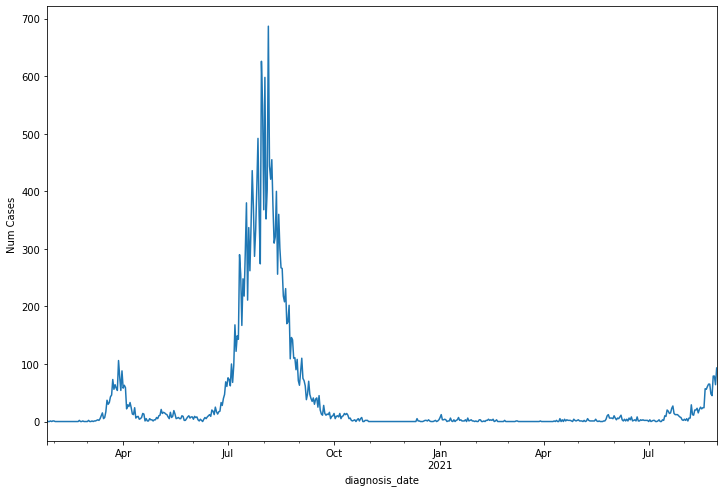

In [8]:
#Chaging the figsize
plt.rcParams["figure.figsize"] = (12,8)

#Lets the plot the data
vic_cases[label].plot()
plt.ylabel("Num Cases");

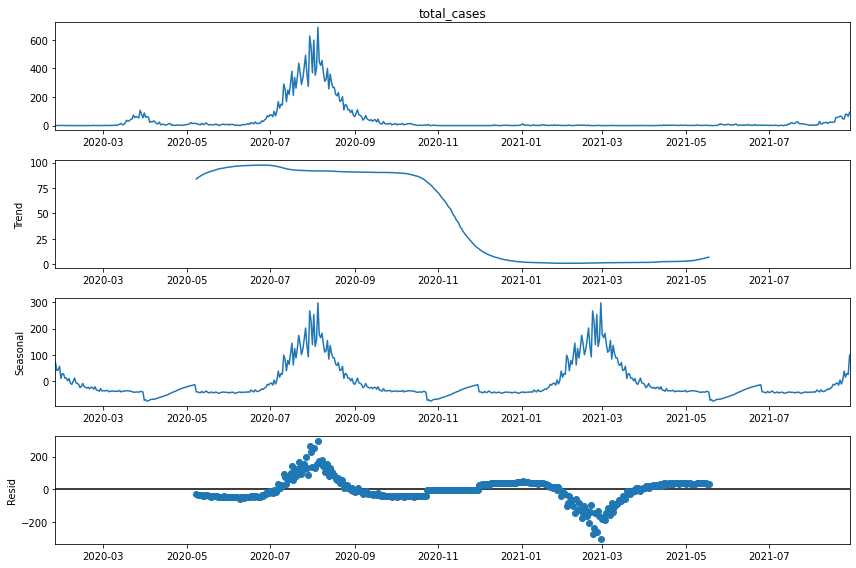

In [9]:
#Lets apply the Seasonal decomposition
results = seasonal_decompose(vic_cases[label], period=207)
results.plot();

# 4 Find the AR, MA, I values using plots and do some statistical tests

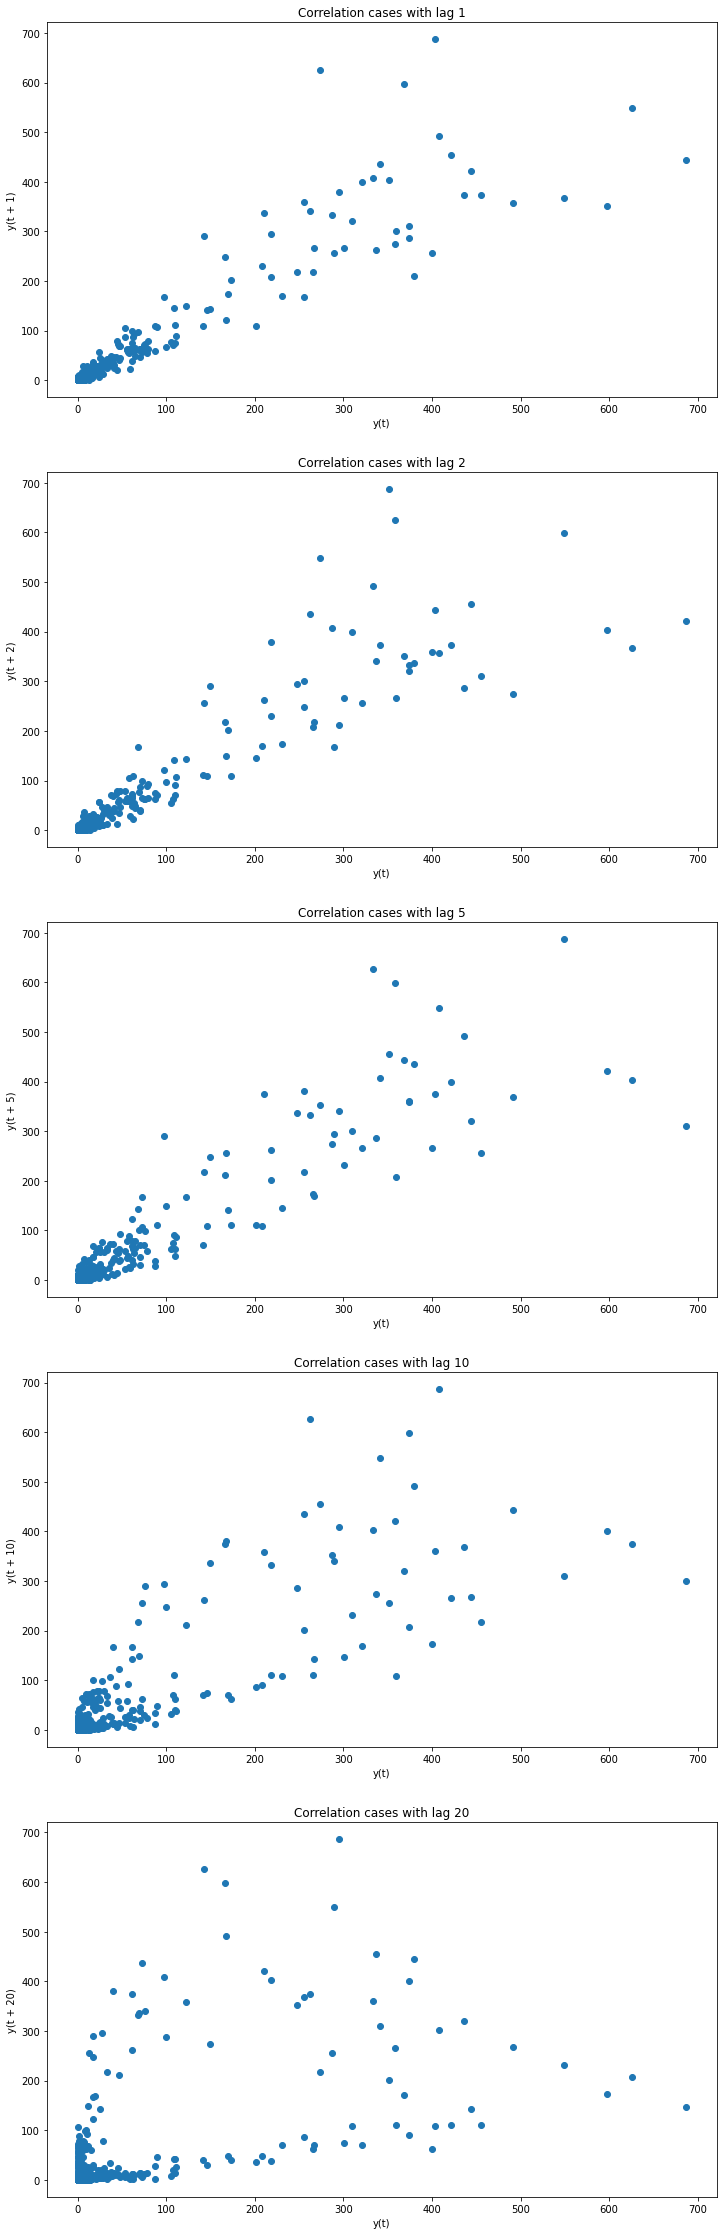

In [10]:
#Lets check if our lags are correlated
total_lags = [1, 2, 5, 10, 20]
fig, axes = plt.subplots(nrows=len(total_lags), ncols=1, figsize=(12,40))
index=0
for lg in total_lags:
    pd.plotting.lag_plot(vic_cases[label], lag=lg, ax=axes[index]);
    axes[index].set_title(f"Correlation cases with lag {lg}")
    index+=1

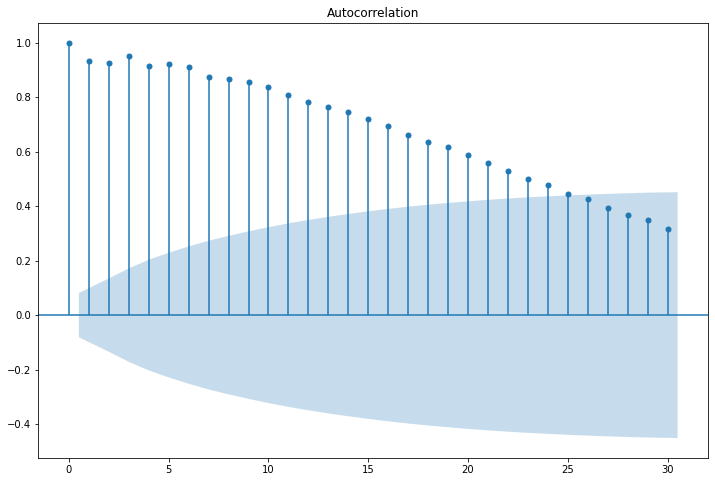

In [11]:
#Lets make it easier and use acf plot, and use this to get the value for AR side of the model
plot_acf(vic_cases[label],lags=30);

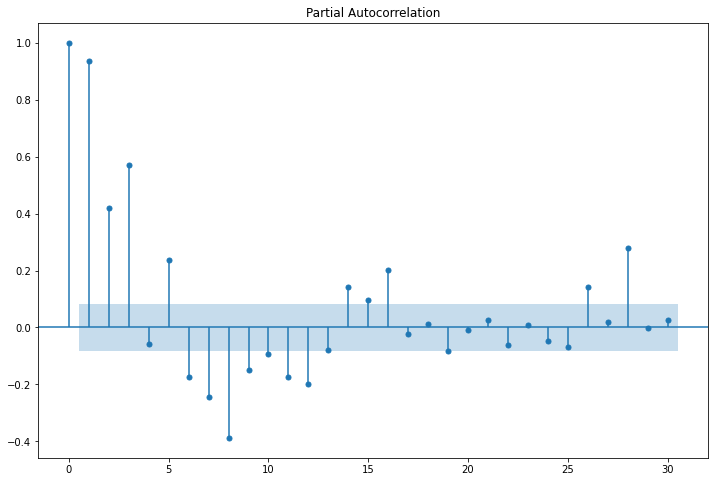

In [12]:
#Lets make it easier and use pacf plot, and use this to get the value for MA side of the model
plot_pacf(vic_cases['total_cases'],lags=30);

In [13]:
#Let check if data is stationary, if value is below 0.05, we can determine data is stationary
def adf_fuller_df(df, colname=""):
    """"The null hypothesis of the Augmented Dickey-Fuller is that there is a unit
        root, which means there is a trend component, with the alternative that 
        there is no unit root, hence no trend component. If the pvalue is above 
        a critical size, then we cannot reject that there is a unit root."""

    df = df.copy()
    vals = adfuller(df[colname])
    first_columns = ["adf", "p-value", "usedlags", "number of observations"]
    other_column = "icbest"
    df = pd.DataFrame(data=pd.Series(vals[0:4], index=first_columns)).T
    for key, val in vals[4].items():
        df[f"Critical value for {key}"] = val
    df[other_column] = vals[5]
    p_value = df["p-value"][0]
    if  p_value <= 0.05:
        print(f"""We should reject the null hypothesis, since there is enough 
        evidence series is stationary, as there is only {np.round(p_value*100,2)} percent
        likelihood, that series is not stationary, and is very small""")
    else:
        print("We should further difference the series with itself ")
    
    return df

In [14]:
adf_fuller_df(vic_cases, label)

We should reject the null hypothesis, since there is enough 
        evidence series is stationary, as there is only 0.94 percent
        likelihood, that series is not stationary, and is very small


,adf,p-value,usedlags,number of observations,Critical value for 1%,Critical value for 5%,Critical value for 10%,icbest
0,-3.447601,0.009439,16.0,565.0,-3.441977,-2.866669,-2.569502,5126.149698


In [15]:
#Can we use auto arima instead to get all values of AR, I and MA
# Based on the plots, we could say AR can be max 21, MA could be max 3 and I is 0

# 5 Run auto arima to find out values for AR, MA and I side of the modes

In [16]:
auto_arima_model = auto_arima(vic_cases[label],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5420.323, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5774.096, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5659.162, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5557.559, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5772.108, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5519.886, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5436.480, Time=0.14 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5422.226, Time=0.26 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5374.246, Time=0.26 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5377.452, Time=0.19 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5343.119, Time=0.36 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5342.700, Time=0.52 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5417.698, Time=0.38 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5325.544, Time=0.64 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  582
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2652.864
Date:                Mon, 30 Aug 2021   AIC                           5321.727
Time:                        11:06:18   BIC                           5356.645
Sample:                             0   HQIC                          5335.340
                                - 582                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4388      0.028     15.744      0.000       0.384       0.493
ar.L2         -0.3110      0.019    -16.241      0.000      -0.349      -0.274
ar.L3          0.4622      0.013     34.486      0.000       0.436       0.489
ar.L4         -0.2142      0.018    -11.875      0.000      -0.250      -0.179
ar.L5          0.4094      0.012     33.346      0.000       0.385       0.434
ma.L1         -1.1607      0.031    -36.945      0.000      -1.222      -1.099
ma.L2          0.4023      0.028     14.453      0.000       0.348       0.457
sigma2       539.2578      8.711     61.909      0.000     522.185     556.330
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             23016.05
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.04   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 6 Lets split the data into training and Test

In [17]:
#Lets split the data into train and testing
train = vic_cases[:"2021-08-24"]
test = vic_cases["2021-08-25":]

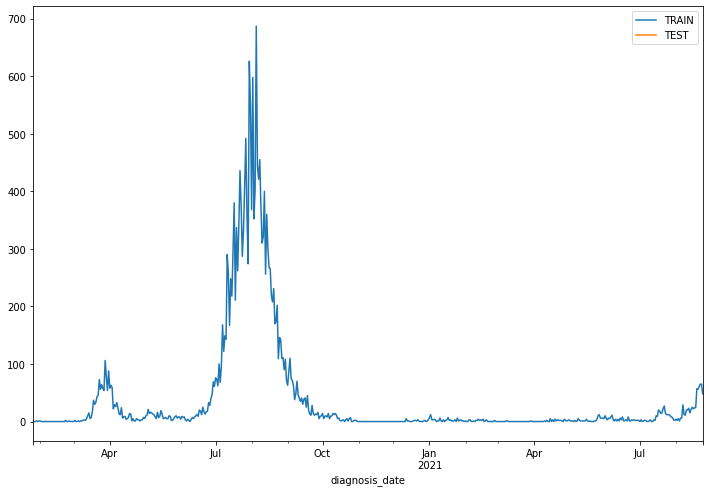

In [18]:
ax = train[label].plot()
ax.plot(test[label])
ax.legend(["TRAIN", "TEST"]);

In [19]:
auto_arima_model = auto_arima(train[label],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5376.760, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5727.587, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5613.366, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5512.568, Time=0.09 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5725.590, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5475.384, Time=0.11 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5392.762, Time=0.23 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5378.660, Time=0.32 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=5329.876, Time=0.35 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5332.849, Time=0.27 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=5300.166, Time=0.75 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=5299.753, Time=0.57 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=5374.404, Time=0.44 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=5282.010, Time=0.69 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  577
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -2631.064
Date:                Mon, 30 Aug 2021   AIC                           5278.129
Time:                        11:06:28   BIC                           5312.978
Sample:                             0   HQIC                          5291.719
                                - 577                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4381      0.028     15.848      0.000       0.384       0.492
ar.L2         -0.3138      0.019    -16.304      0.000      -0.352      -0.276
ar.L3          0.4602      0.014     34.069      0.000       0.434       0.487
ar.L4         -0.2137      0.018    -11.842      0.000      -0.249      -0.178
ar.L5          0.4107      0.012     33.188      0.000       0.386       0.435
ma.L1         -1.1621      0.031    -37.251      0.000      -1.223      -1.101
ma.L2          0.4075      0.028     14.792      0.000       0.353       0.461
sigma2       541.1593      8.777     61.656      0.000     523.957     558.362
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22905.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 7 Train the model based on ARIMA terms from Auto arima

In [20]:
#train the data based on the parameters we got
arima_model = ARIMA(train[label], order=(5,1,2)).fit()
arima_model.summary()

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationa

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:            total_cases   No. Observations:                  577
Model:                 ARIMA(5, 1, 2)   Log Likelihood               -2631.064
Date:                Mon, 30 Aug 2021   AIC                           5278.129
Time:                        11:06:29   BIC                           5312.978
Sample:                    01-26-2020   HQIC                          5291.719
                         - 08-24-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4381      0.028     15.848      0.000       0.384       0.492
ar.L2         -0.3138      0.019    -16.304      0.000      -0.352      -0.276
ar.L3          0.4602      0.014     34.069      0.000       0.434       0.487
ar.L4         -0.2137      0.018    -11.842      0.000      -0.249      -0.178
ar.L5          0.4107      0.012     33.188      0.000       0.386       0.435
ma.L1         -1.1621      0.031    -37.251      0.000      -1.223      -1.101
ma.L2          0.4075      0.028     14.792      0.000       0.353       0.461
sigma2       541.1593      8.777     61.656      0.000     523.957     558.362
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             22905.99
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 8 Make predictions

In [21]:
#Predict the model
start = train.shape[0] 
end = train.shape[0] + test.shape[0] - 1
arima_predictions = arima_model.predict(start=start, end=end)

In [22]:
results=test
test["predictions"] = [p for p in arima_predictions]

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_11569/4087890050.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["predictions"] = [p for p in arima_predictions]


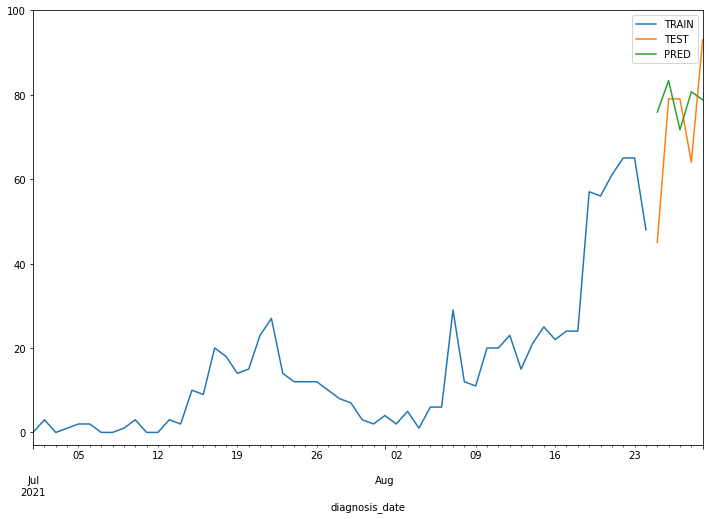

In [23]:
#plotting the results
ax = train[label].plot()
ax.plot(test[label])
ax.plot(test["predictions"])
ax.set_xlim(date(2021,7,1),date(2021,8,29))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED"]);

# 9 Evaluate the model

In [24]:
#measure performance
RMSE=rmse(results[label], results.predictions)
MSE=mse(results[label], results.predictions)

print(f"rmse is {RMSE}")
print(f"mse is {MSE}")
print("mean is {}".format(test[label].mean()))
print("std is {}".format(test[label].std()))

rmse is 17.35752023031961
mse is 301.28350854595453
mean is 72.0
std is 18.24828759089466


# 10 Lets try model building training, testing with Fb Prophet Library

In [25]:
#The library like dates in DS column and target variable in Y
vic_cases = vic_cases.reset_index()
vic_cases = vic_cases.rename(columns={label:"y", date_column:"ds"})
vic_cases.head()

,ds,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,y
0,2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0
1,2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0
4,2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
#splitting data into training and testing
trainX=vic_cases[:-test.shape[0]][["ds","y"]]
textX=vic_cases[-test.shape[0]:][["ds","y"]]

In [27]:
#Train the model

#Define the model
fb_model=Prophet()

#Fit the model
fb_model.fit(trainX)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.16025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       936.163    0.00559992       188.995   4.278e-05       0.001      117  LS failed, Hessian reset 
      99       940.172   0.000611719       68.1928      0.3078           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       946.442    0.00882248       242.707    0.000103       0.001      285  LS failed, Hessian reset 
     199       947.817   0.000261819       54.1567      0.7152      0.7152      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       947.852   5.49617e-05       66.9468   8.445e-07       0.001      445  LS failed, Hessian reset 
     260       947.854    1.4841e-05       48.5703   1.677e-07       0.001      511  LS failed, Hessian reset 
     284       947.855   7.27674e-08        79.379      0.3491   

In [28]:
#future dates
future = fb_model.make_future_dataframe(periods=test.shape[0])
future.tail(test.shape[0])

,ds
577,2021-08-25
578,2021-08-26
579,2021-08-27
580,2021-08-28
581,2021-08-29


In [29]:
#forecast
fb_predictions=fb_model.predict(future)
fb_predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])


,ds,yhat,yhat_lower,yhat_upper
577,2021-08-25,11.056196,-80.056744,102.411270
578,2021-08-26,11.582895,-77.256346,94.402671
579,2021-08-27,9.844265,-76.459740,107.054389
580,2021-08-28,9.070671,-74.231254,98.844891
581,2021-08-29,12.136028,-81.961891,99.850263


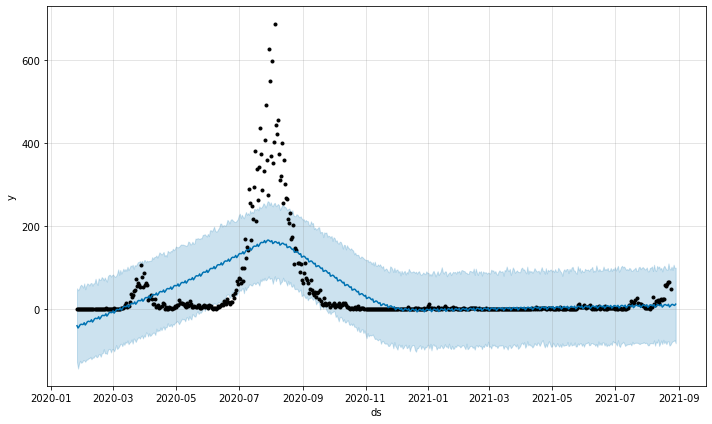

In [30]:
#plot the data
fig1 = fb_model.plot(fb_predictions)


In [31]:
train[label] = train[label].astype(float)
test[label] = test[label].astype(float)

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_11569/4049480995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train[label] = train[label].astype(float)
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_11569/4049480995.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[label] = test[label].astype(float)


In [32]:
ets_model = ets.ETSModel(train[label], freq='D', error='add').fit()
predictions_ets = ets_model.predict(start=start, end=end)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.20129D+00    |proj g|=  8.99900D-01

At iterate    1    f=  4.96748D+00    |proj g|=  4.27682D-01

At iterate    2    f=  4.82440D+00    |proj g|=  3.23162D-01

At iterate    3    f=  4.77886D+00    |proj g|=  1.80745D-02

At iterate    4    f=  4.77880D+00    |proj g|=  8.44658D-05

At iterate    5    f=  4.77880D+00    |proj g|=  2.13163D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      7     0     0   

In [33]:
fb_pred = fb_predictions[["ds","yhat"]][-test.shape[0]:]
fb_pred.set_index("ds", inplace=True)

In [34]:
fb_pred

,yhat
ds,
2021-08-25,11.056196
2021-08-26,11.582895
2021-08-27,9.844265
2021-08-28,9.070671
2021-08-29,12.136028


# 11 Create ensemble of three models and visualise the results

In [35]:
#Ensemble predictions
ensemble = (fb_pred.yhat + predictions_ets + test.predictions)/3

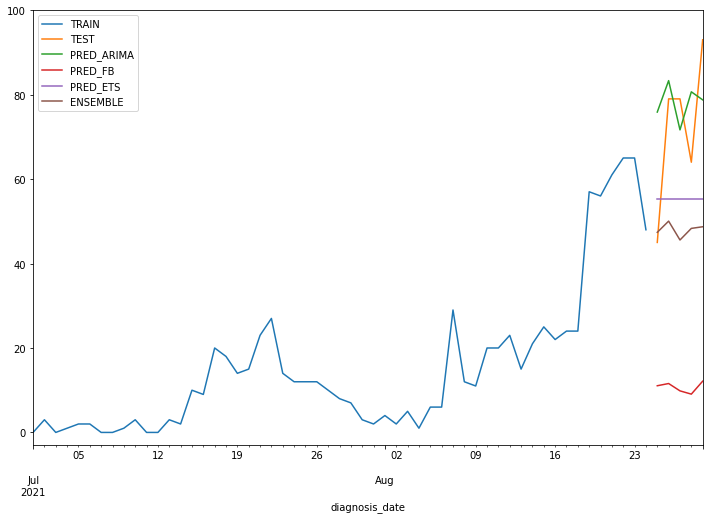

In [36]:
ax = train[label].plot()
ax.plot(test[label])
ax.plot(test["predictions"])
ax.plot(fb_pred['yhat'])
ax.plot(predictions_ets)
ax.plot(ensemble)
ax.set_xlim(date(2021,7,1),date(2021,8,29))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_ARIMA","PRED_FB", "PRED_ETS","ENSEMBLE"]);

# 12 Add some exogenous variables to the model and try make better predictions

In [37]:
data.head()

,diagnosis_date,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation
0,2020-01-26,1.0,0.0,0.0,0.0,0.0
1,2020-01-27,0.0,0.0,0.0,0.0,0.0
2,2020-01-28,0.0,0.0,0.0,0.0,0.0
3,2020-01-29,1.0,0.0,0.0,0.0,0.0
4,2020-01-30,0.0,0.0,0.0,0.0,0.0


In [38]:
#Adding some features
vic_cases_wf = data[[date_column, "Overseas","Known Local","Unknown Local (Community)", "Interstate (N/A)", "Under Investigation"]][:-1]
#Formatting the index
vic_cases_wf.set_index(date_column, inplace=True)
vic_cases_wf[label] = vic_cases_wf[vic_cases_wf.columns].sum(axis=1)
vic_cases_wf["Unknown Local (Community)"] = vic_cases_wf[["Unknown Local (Community)", "Under Investigation"]].sum(axis=1)
vic_cases_wf["Community"] = vic_cases_wf[["Unknown Local (Community)","Known Local"]].sum(axis=1)
vic_cases_wf["lockdown"] = vic_cases_wf["Community"].apply(lambda val: 1 if val >= 10 else 0)

#Adding the delta feature
vic_cases_wf["delta"] = vic_cases_wf.index.map(lambda val : 1 if val >= date(2021,6,1) else 0 )

#print the shape
print(vic_cases_wf.shape)

vic_cases_wf.head()

(582, 9)


/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_11569/3017244564.py:11: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  vic_cases_wf["delta"] = vic_cases_wf.index.map(lambda val : 1 if val >= date(2021,6,1) else 0 )


,Overseas,Known Local,Unknown Local (Community),Interstate (N/A),Under Investigation,total_cases,Community,lockdown,delta
diagnosis_date,,,,,,,,,
2020-01-26,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2020-01-27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-01-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
2020-01-29,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0
2020-01-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


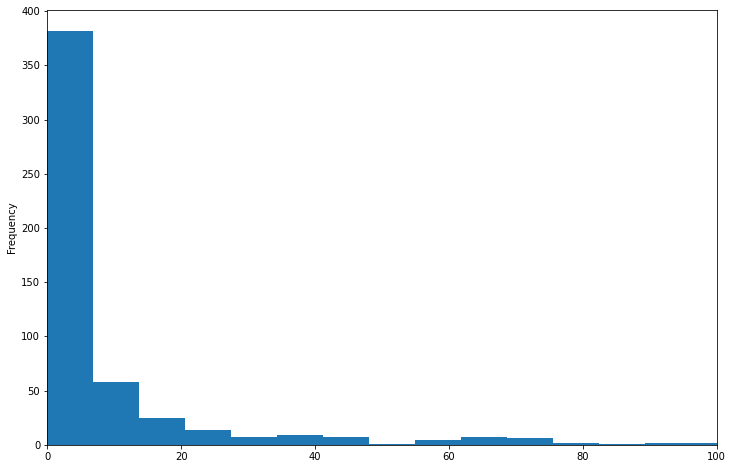

In [39]:
#Lets visualise number of common cases
vic_cases_wf["Community"].plot.hist(bins=100)
plt.xlim(0,100);

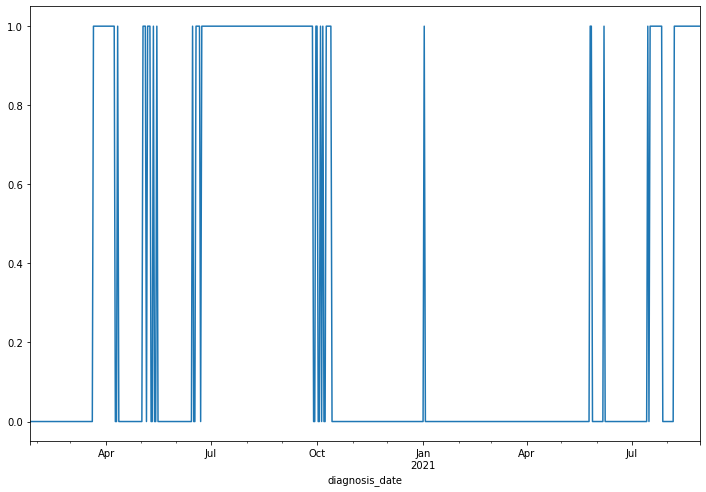

In [40]:
#Plotting the lockdown
vic_cases_wf.lockdown.plot();

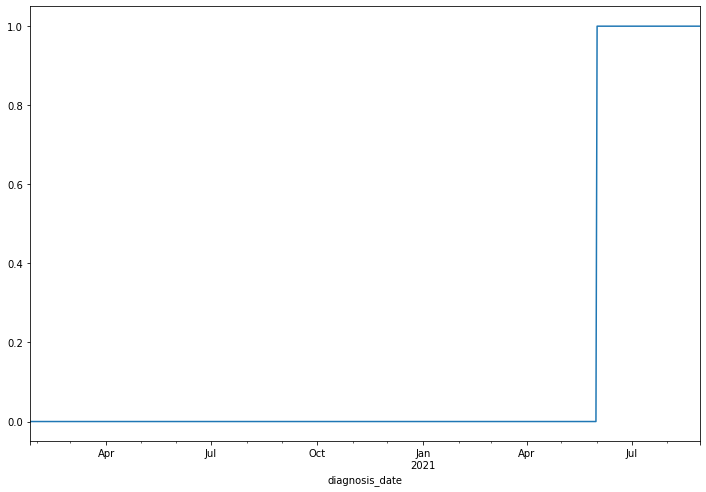

In [41]:
#Plotting delta
vic_cases_wf.delta.plot();

In [42]:
#features to include in the model
features = ["delta","lockdown","Unknown Local (Community)"]

In [43]:
#Subsetting the data
vic_cases_wf_final = vic_cases_wf[features + [label]]
vic_cases_wf_final = vic_cases_wf_final.rename(columns={label:"y"})
vic_cases_wf_final.index.rename("ds", inplace=True)
vic_cases_wf_final.head()

,delta,lockdown,Unknown Local (Community),y
ds,,,,
2020-01-26,0,0,0.0,1.0
2020-01-27,0,0,0.0,0.0
2020-01-28,0,0,0.0,0.0
2020-01-29,0,0,0.0,1.0
2020-01-30,0,0,0.0,0.0


In [44]:
#Lets split the data into train and testing
train = vic_cases_wf_final[:"2021-08-24"]
test = vic_cases_wf_final["2021-08-25":]

In [45]:
model = MinMaxScaler()
model.fit(train[["Unknown Local (Community)"]])
train["Unknown Local (Community)"] = model.transform(train[["Unknown Local (Community)"]])
test["Unknown Local (Community)"] = model.transform(test[["Unknown Local (Community)"]])

/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_11569/3985348790.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Unknown Local (Community)"] = model.transform(train[["Unknown Local (Community)"]])
/var/folders/6f/p7312_7n4nq5hp35rfymms1h0000gn/T/ipykernel_11569/3985348790.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Unknown Local (Community)"] = model.transform(test[["Unknown Local (Community)"]])


In [46]:
auto_arima_model = auto_arima(train["y"],
                               X=train[features],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=True, 
                               random_state=42, #seed
                               n_fits=10,
                               m=7,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[7] intercept   : AIC=4980.698, Time=1.20 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=5407.352, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=5034.606, Time=0.66 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=5197.935, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=5406.279, Time=0.09 sec
 ARIMA(2,0,2)(0,0,1)[7] intercept   : AIC=4969.455, Time=1.00 sec
 ARIMA(2,0,2)(0,0,0)[7] intercept   : AIC=4943.691, Time=0.70 sec
 ARIMA(2,0,2)(1,0,0)[7] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,0,2)(0,0,0)[7] intercept   : AIC=4901.685, Time=0.58 sec
 ARIMA(1,0,2)(1,0,0)[7] intercept   : AIC=4987.363, Time=0.81 sec
 ARIMA(1,0,2)(0,0,1)[7] intercept   : AIC=4901.251, Time=0.93 sec
 ARIMA(1,0,2)(1,0,1)[7] intercept   : AIC=4985.362, Time=1.07 sec
 ARIMA(1,0,2)(0,0,2)[7] intercept   : AIC=4909.191, Time=1.71 sec
 ARIMA(1,0,2)(1,0,2)[7] intercept   : AIC=4971.225, Time=2.15 sec
 ARIMA(0,0,2)(0,0,1)[7] intercept   : 

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                  577
Model:             SARIMAX(1, 0, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -2436.655
Date:                                Mon, 30 Aug 2021   AIC                           4891.310
Time:                                        11:07:05   BIC                           4930.530
Sample:                                    01-26-2020   HQIC                          4906.604
                                         - 08-24-2021                                         
Covariance Type:                                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
intercept                     0.2070      0.440      0.471      0.638      -0.655       1.069
delta                         3.0631     58.967      0.052      0.959    -112.510     118.637
lockdown                      6.4182      6.640      0.967      0.334      -6.595      19.432
Unknown Local (Community)   492.0836      5.034     97.758      0.000     482.218     501.950
ar.L1                         0.9831      0.005    188.620      0.000       0.973       0.993
ma.L1                        -0.5783      0.014    -40.050      0.000      -0.607      -0.550
ma.S.L7                      -0.1083      0.021     -5.088      0.000      -0.150      -0.067
ma.S.L14                     -0.1110      0.020     -5.506      0.000      -0.151      -0.072
sigma2                      271.8710      5.147     52.824      0.000     261.784     281.958
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             19608.68
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             2.84
Prob(H) (two-sided):                  0.00   Kurtosis:                        30.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
auto_arima_model = auto_arima(train["y"],
                               X=train[features],
                               max_p=30, 
                               max_q=30, 
                               max_order=62, 
                               n_jobs=1, 
                               seasonal=False, 
                               random_state=42, #seed
                               n_fits=10,
                               trace=True
                             )
#Getting the summary from the model
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=5406.279, Time=0.09 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=5042.113, Time=0.31 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=5224.239, Time=0.29 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=4979.253, Time=0.38 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=4865.888, Time=0.45 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=inf, Time=0.54 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=4868.790, Time=0.53 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=4909.626, Time=0.42 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=inf, Time=0.59 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=0.53 sec

Best model:  ARIMA(3,0,0)(0,0,0)[0]          
Total fit time: 4.719 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  577
Model:               SARIMAX(3, 0, 0)   Log Likelihood               -2425.944
Date:                Mon, 30 Aug 2021   AIC                           4865.888
Time:                        11:07:09   BIC                           4896.393
Sample:                    01-26-2020   HQIC                          4877.784
                         - 08-24-2021                                         
Covariance Type:                  opg                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
delta                        14.3005     18.219      0.785      0.433     -21.409      50.010
lockdown                      6.0095      6.152      0.977      0.329      -6.048      18.067
Unknown Local (Community)   444.2120      6.276     70.777      0.000     431.911     456.513
ar.L1                         0.4497      0.012     38.925      0.000       0.427       0.472
ar.L2                         0.0583      0.015      3.906      0.000       0.029       0.088
ar.L3                         0.4502      0.012     38.446      0.000       0.427       0.473
sigma2                      262.1554      5.019     52.233      0.000     252.319     271.992
===================================================================================
Ljung-Box (L1) (Q):                   0.38   Jarque-Bera (JB):             14174.85
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               0.03   Skew:                             1.85
Prob(H) (two-sided):                  0.00   Kurtosis:                        27.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [48]:
#Train the models
sarmia_model_exog=SARIMAX(train["y"], exog=train[features],order=(1,0,1), seasonal_order=(0,0,2,7), freq="D", max_iter=200).fit()
arima_model_exog=ARIMA(train["y"], exog=train[features], order=(3,0,0)).fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.38394D+00    |proj g|=  2.53661D-01



/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
 This problem is unconstrained.


At iterate    5    f=  4.32444D+00    |proj g|=  6.85144D-03

At iterate   10    f=  4.32233D+00    |proj g|=  2.30996D-03

At iterate   15    f=  4.31848D+00    |proj g|=  4.65058D-02

At iterate   20    f=  4.30356D+00    |proj g|=  5.58708D-03

At iterate   25    f=  4.30119D+00    |proj g|=  1.15872D-03

At iterate   30    f=  4.30027D+00    |proj g|=  4.53205D-03

At iterate   35    f=  4.23536D+00    |proj g|=  6.54708D-02

At iterate   40    f=  4.23045D+00    |proj g|=  1.03187D-03

At iterate   45    f=  4.23041D+00    |proj g|=  1.19957D-04

At iterate   50    f=  4.23041D+00    |proj g|=  5.73408D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency info

In [49]:
sarima_exog_pred=sarmia_model_exog.predict(start=start, end=end, exog=test[features])
arima_exog_pred=arima_model_exog.predict(start=start, end=end, exog=test[features])

# 13 Visualise the predictions against actual data after retraining with variables

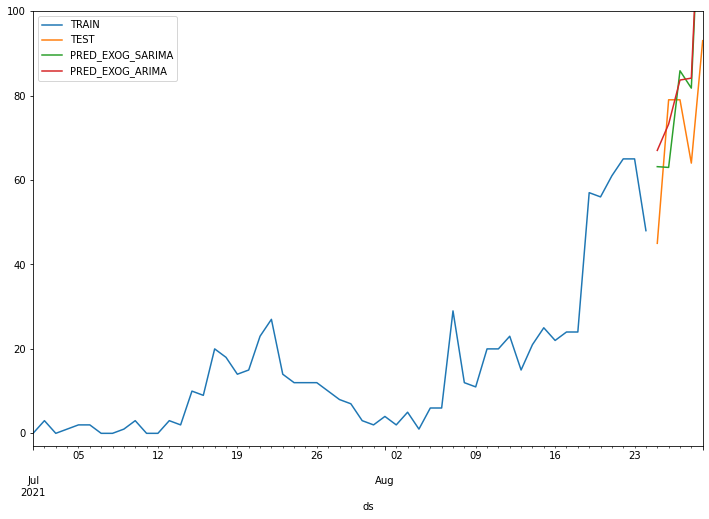

In [50]:
ax = train["y"].plot()
ax.plot(test["y"])
ax.plot(sarima_exog_pred)
ax.plot(arima_exog_pred)
ax.set_xlim(date(2021,7,1),date(2021,8,29))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_EXOG_SARIMA","PRED_EXOG_ARIMA"]);

# 14 Adding variables to FB model and predicting in the future

In [51]:
#Prepare training and testing data for FB prophet
train = train.reset_index()
test = test.reset_index()
fb_train = train[["ds","y"] + features]
fb_test = test[["ds","y"] + features]

In [52]:
#Traing fb with exog variables
fb_model_exog = Prophet()
for _ in features:
    fb_model_exog.add_regressor(_)
fb_model_exog.fit(fb_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.16025


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1610.42    0.00278128       102.294           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       1611.86    0.00107383       224.159   8.579e-06       0.001      236  LS failed, Hessian reset 
     199       1612.99    0.00430434       119.953           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1615.13      0.023759       193.172           1           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1618.26    0.00014954        64.345           1           1      520   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     487       1618.36   8.28123e-05       65.9128   1.205e-06       0.001      6

In [53]:
#Lets make predictions for the model
fb_exog_future = fb_model_exog.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future[_] = [val for val in vic_cases_wf_final[_]]
fb_exog_forecast = fb_model_exog.predict(fb_exog_future)
#forecast
fb_exog_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

65  LS failed, Hessian reset 
     499       1618.37   2.23854e-05       49.7175           1           1      683   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     547       1618.41   2.05838e-05       64.7357    2.85e-07       0.001      781  LS failed, Hessian reset 
     599       1618.41   2.00965e-06       78.8456      0.3005           1      846   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     625       1618.41   5.68047e-08       76.0326       0.277      0.9088      879   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


,ds,yhat,yhat_lower,yhat_upper
577,2021-08-25,47.548653,16.921749,76.692061
578,2021-08-26,53.069425,24.654893,84.485175
579,2021-08-27,81.033928,47.857304,111.214018
580,2021-08-28,72.798173,40.073672,101.845616
581,2021-08-29,154.529735,123.677037,186.693200


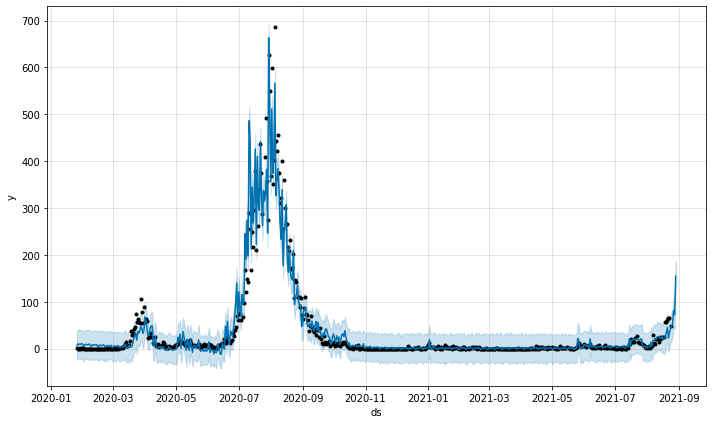

In [54]:
#plot the data
fig1 = fb_model_exog.plot(fb_exog_forecast)

In [55]:
#Ensemble predictions
fb_exog_pred = fb_exog_forecast[["ds","yhat"]][-test.shape[0]:]
fb_exog_pred.set_index("ds", inplace=True)
ensemble_exog = (fb_exog_pred.yhat + sarima_exog_pred + arima_exog_pred)/3
train.set_index("ds", inplace=True)
test.set_index("ds", inplace=True)

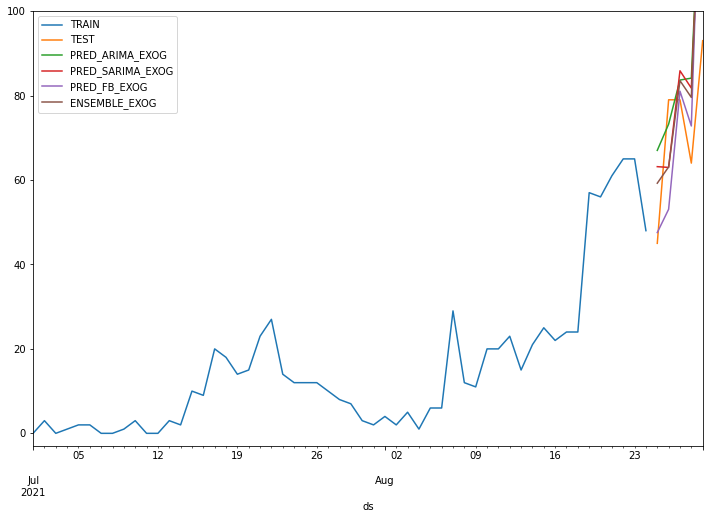

In [56]:
#Plotting all the models
ax = train["y"].plot()
ax.plot(test["y"])
ax.plot(arima_exog_pred)
ax.plot(sarima_exog_pred)
ax.plot(fb_exog_pred)
ax.plot(ensemble_exog)
ax.set_xlim(date(2021,7,1),date(2021,8,29))
ax.set_ylim(-3,100)
ax.legend(["TRAIN", "TEST", "PRED_ARIMA_EXOG","PRED_SARIMA_EXOG", "PRED_FB_EXOG","ENSEMBLE_EXOG"]);

# 15 Looking for seasonal component in model

In [57]:
#is there a seasonal component?
#Traing fb with exog variables
fb_model_exog_s = Prophet(daily_seasonality=True)
for _ in features:
    fb_model_exog_s.add_regressor(_)
fb_model_exog_s.fit(fb_train)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.16025


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1608.24    0.00137666        244.97           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159          1610   0.000453641       120.386   7.103e-06       0.001      246  LS failed, Hessian reset 
     199       1610.66    0.00458312        186.94           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       1611.57   8.43406e-05       117.557   4.405e-07       0.001      374  LS failed, Hessian reset 
     299       1613.04   2.37381e-05       89.2912      0.4223      0.4223      486   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       1618.27   2.84224e-05        94.891     0.05334     0.05334      606   
    Iter      log prob        ||dx||      ||grad||       alpha

In [58]:
#Lets make predictions for the model
fb_exog_future_s = fb_model_exog_s.make_future_dataframe(periods=test.shape[0])
for _ in features:
    fb_exog_future_s[_] = [val for val in vic_cases_wf_final[_]]
fb_exog_forecast_s = fb_model_exog.predict(fb_exog_future_s)
#forecast
fb_exog_forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

,ds,yhat,yhat_lower,yhat_upper
577,2021-08-25,47.548653,14.327939,77.788347
578,2021-08-26,53.069425,22.544438,82.643502
579,2021-08-27,81.033928,51.275290,111.402366
580,2021-08-28,72.798173,41.746825,103.517830
581,2021-08-29,154.529735,123.030935,185.531041


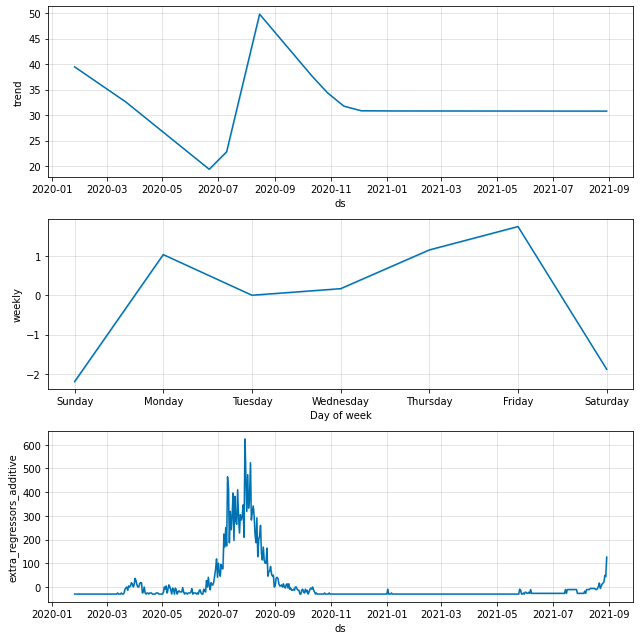

In [59]:
fb_model_exog_s.plot_components(fb_exog_forecast_s);

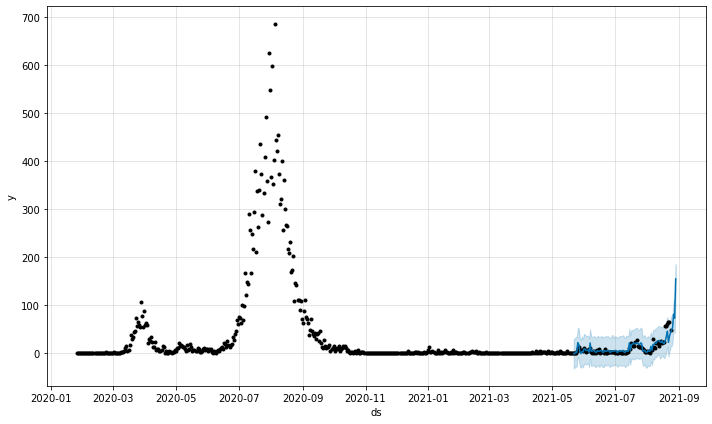

In [60]:
fb_model_exog_s.plot(fb_exog_forecast_s[-100:]);

In [61]:
fb_exog_forecast_s.set_index("ds", inplace=True)
RMSE = rmse(test["y"], fb_exog_forecast_s["yhat"][-test.shape[0]:])
print(f"RMSE in fb model is {RMSE}")

RMSE in fb model is 30.154082289988615


In [62]:
fb_exog_forecast.set_index("ds", inplace=True)
RMSE = rmse(test["y"], fb_exog_forecast["yhat"][-test.shape[0]:])
print(f"RMSE in fb model is {RMSE}")

RMSE in fb model is 30.154082289988615


In [63]:
RMSE = rmse(test["y"], arima_exog_pred)
print(f"RMSE in arima exog model is {RMSE}")

RMSE in arima exog model is 26.450056958232967


In [64]:
RMSE = rmse(test["y"], sarima_exog_pred)
print(f"RMSE in sarima exog model is {RMSE}")

RMSE in sarima exog model is 26.01651208140622


In [65]:
RMSE = rmse(test["y"], ensemble_exog)
print(f"RMSE in sarima exog model is {RMSE}")

RMSE in sarima exog model is 26.88147607423698


# 16 Lets forecast in the unknown future

In [66]:
model = MinMaxScaler()
model.fit(vic_cases_wf_final[["Unknown Local (Community)"]])
vic_cases_wf_final["Unknown Local (Community)"] = model.transform(vic_cases_wf_final[["Unknown Local (Community)"]])

In [67]:
#Lets do a forecast finally
arima_model_exog=ARIMA(vic_cases_wf_final["y"], exog=vic_cases_wf_final[features],order=(3,0,0)).fit()
sarima_model_exog=SARIMAX(vic_cases_wf_final["y"], exog=vic_cases_wf_final[features],order=(1,0,1), seasonal_order=(0,0,2,7)).fit()
fb_full = pd.concat([fb_train, fb_test], axis=0, ignore_index=True)
fb_model_exog_s = Prophet(daily_seasonality=True)
for _ in features:
    fb_model_exog_s.add_regressor(_)
fb_model_exog_s.fit(fb_full)

/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39030D+00    |proj g|=  2.49119D-01

At iterate    5    f=  4.33268D+00    |proj g|=  7.31779D-03

At iterate   10    f=  4.33055D+00    |proj g|=  2.70752D-03

At iterate   15    f=  4.32556D+00    |proj g|=  5.80286D-02

At iterate   20    f=  4.30912D+00    |proj g|=  1.71222D-03

At iterate   25    f=  4.30878D+00    |proj g|=  5.62671D-03

At iterate   30    f=  4.29795D+00    |proj g|=  7.28875D-02

At iterate   35    f=  4.23986D+00    |proj g|=  7.12792D-02

At iterate   40    f=  4.23527D+00    |proj g|=  1.54268D-03

At iterate   45    f=  4.23520D+00    |proj g|=  3.06210D-05


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.



At iterate   50    f=  4.23519D+00    |proj g|=  7.81337D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     54      1     0     0   7.813D-04   4.235D+00
  F =   4.2351944388574010     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Initial log joint probability = -8.73657


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1620.47    0.00277232       265.235      0.1896      0.7969      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1623.94     0.0140919       260.729           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       1625.93   0.000244925       82.5084           1           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     336       1626.09   5.92877e-05       77.5012   4.098e-07       0.001      462  LS failed, Hessian reset 
     366       1626.16   5.73237e-05       106.112   6.837e-07       0.001      533  LS failed, Hessian reset 
     399       1626.17   1.92735e-05       77.1378           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha

In [68]:
#Lets make predictions for the model
fb_exog_future_s = fb_model_exog_s.make_future_dataframe(periods=test.shape[0])
for _ in features:
    if _ != "Unknown Local (Community)":
        fb_exog_future_s[_] = [val for val in vic_cases_wf_final[_]] + list(np.ones(test.shape[0]))
    else:
        fb_exog_future_s["Unknown Local (Community)"] = vic_cases_wf_final[-1:]["Unknown Local (Community)"].values[0]
fb_exog_forecast_s = fb_model_exog.predict(fb_exog_future_s)
#forecast
fb_exog_forecast_s[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(test.shape[0])

,ds,yhat,yhat_lower,yhat_upper
582,2021-08-30,157.813879,128.460669,187.601949
583,2021-08-31,156.743398,127.159163,187.281545
584,2021-09-01,156.936059,126.932494,188.952290
585,2021-09-02,157.898984,128.181942,186.666138
586,2021-09-03,158.516407,130.562493,187.817975


In [69]:
#Foreasting arima and sarima
arima_exog_future=fb_exog_forecast_s[["ds"]][-test.shape[0]:]

#Adding exogenous variables
for _ in features:
    if _ != "Unknown Local (Community)":
        arima_exog_future[_] = 1
    else:
        arima_exog_future[_] = vic_cases_wf_final[-1:]["Unknown Local (Community)"].values[0]
arima_exog_future.set_index("ds", inplace=True)
start=vic_cases_wf_final.shape[0]
end=vic_cases_wf_final.shape[0] + test.shape[0] -1

#Forecasts
arima_exog_forecast = arima_model_exog.predict(start=start, end=end, exog=arima_exog_future[features])
sarima_exog_forecast = sarima_model_exog.predict(start=start, end=end, exog=arima_exog_future[features])

In [70]:
#extracting fb porphet forecast and adding the ensemble model
fb_exog_forecast_s = fb_exog_forecast_s[["ds","yhat"]][-test.shape[0]:]
fb_exog_forecast_s.set_index("ds", inplace=True)
ensemble_exog_forecast = (fb_exog_forecast_s.yhat + sarima_exog_forecast + arima_exog_forecast)/3

# 17 Making predictions with our four models

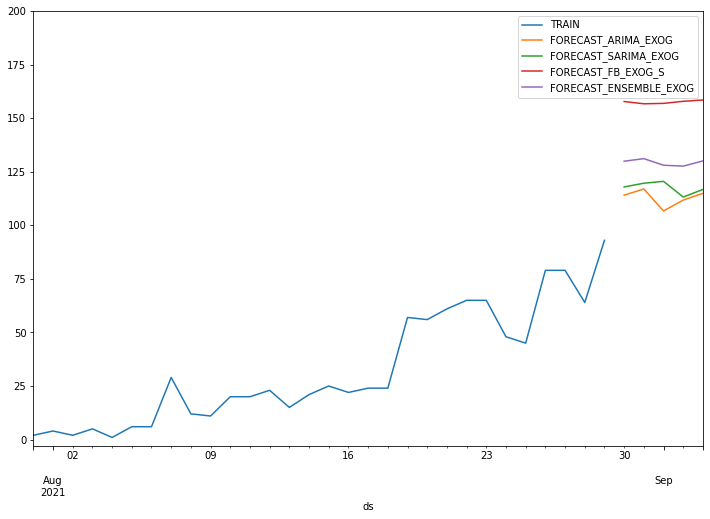

In [71]:
#Plotting all the models in uknown future
ax = vic_cases_wf_final["y"].plot()
ax.plot(arima_exog_forecast)
ax.plot(sarima_exog_forecast)
ax.plot(fb_exog_forecast_s)
ax.plot(ensemble_exog_forecast)
ax.set_xlim(date(2021,7,31),date(2021,9,3))
ax.set_ylim(-3,200)
ax.legend(["TRAIN", "FORECAST_ARIMA_EXOG","FORECAST_SARIMA_EXOG", "FORECAST_FB_EXOG_S", "FORECAST_ENSEMBLE_EXOG"]);

In [72]:
print(sarima_exog_forecast)

2021-08-30    117.925513
2021-08-31    119.666032
2021-09-01    120.532696
2021-09-02    113.211140
2021-09-03    116.758912
Freq: D, Name: predicted_mean, dtype: float64


In [73]:
print(arima_exog_forecast)

2021-08-30    114.092007
2021-08-31    116.985067
2021-09-01    106.714045
2021-09-02    111.807132
2021-09-03    114.967292
Freq: D, Name: predicted_mean, dtype: float64


In [74]:
print(ensemble_exog_forecast)

ds
2021-08-30    129.943800
2021-08-31    131.131499
2021-09-01    128.060933
2021-09-02    127.639085
2021-09-03    130.080870
dtype: float64


In [75]:
print(fb_exog_forecast_s)

                  yhat
ds                    
2021-08-30  157.813879
2021-08-31  156.743398
2021-09-01  156.936059
2021-09-02  157.898984
2021-09-03  158.516407


# 18 Lets try advanced model called neural prophet that uses AR-NET or neural networks for timeseries, another tool developed by facebook and uses pytorch as the backend

In [76]:
%%time
fb_neural_model = NeuralProphet(epochs=1000, n_forecasts=5, n_lags=3)
for _ in features:
    fb_neural_model.add_lagged_regressor(_)
fb_neural_metrics = fb_neural_model.fit(fb_full, freq='D')

INFO: nprophet.utils - set_auto_seasonalities: Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO:nprophet.utils:Disabling yearly seasonality. Run NeuralProphet with yearly_seasonality=True to override this.
INFO: nprophet.utils - set_auto_seasonalities: Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO:nprophet.utils:Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO: nprophet.config - set_auto_batch_epoch: Auto-set batch_size to 8
INFO:nprophet.config:Auto-set batch_size to 8


  0%|          | 0/100 [00:00<?, ?it/s]

INFO: nprophet - _lr_range_test: learning rate range test found optimal lr: 2.31E-01
INFO:nprophet:learning rate range test found optimal lr: 2.31E-01
Epoch[1000/1000]: 100%|█| 1000/1000 [01:45<00:00,  9.47it/s, SmoothL1Loss=0.0231

CPU times: user 1min 44s, sys: 960 ms, total: 1min 45s
Wall time: 1min 45s


In [77]:
#Lets make predictions for the model
fb_neural_future = fb_neural_model.make_future_dataframe(df=fb_full, periods=test.shape[0])
for _ in features:
    if _ != "Unknown Local (Community)":
        fb_neural_future[_].iloc[-test.shape[0]:] = list(np.ones(test.shape[0]))
    else:
        fb_neural_future["Unknown Local (Community)"] = fb_full[-1:]["Unknown Local (Community)"].values[0]
    
fb_neural_forecast = fb_neural_model.predict(fb_neural_future)
fb_neural_forecast.head()


/Users/bajajn/forecasting-part-two/forecasting/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,ds,y,yhat1,residual1,yhat2,residual2,yhat3,residual3,yhat4,residual4,...,lagged_regressor_lockdown3,lagged_regressor_lockdown4,lagged_regressor_lockdown5,lagged_regressor_Unknown Local (Community)1,lagged_regressor_Unknown Local (Community)2,lagged_regressor_Unknown Local (Community)3,lagged_regressor_Unknown Local (Community)4,lagged_regressor_Unknown Local (Community)5,trend,season_weekly
0,2021-08-27,79.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
1,2021-08-28,64.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
2,2021-08-29,93.0,None,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,None,None,None,None,None,None,None
3,2021-08-30,NaN,68.484718,NaN,None,NaN,None,NaN,None,NaN,...,None,None,None,7.009496,None,None,None,None,-2.407629,-4.353437
4,2021-08-31,NaN,None,NaN,55.817116,NaN,None,NaN,None,NaN,...,None,None,None,None,8.57654,None,None,None,-2.357217,-2.377472


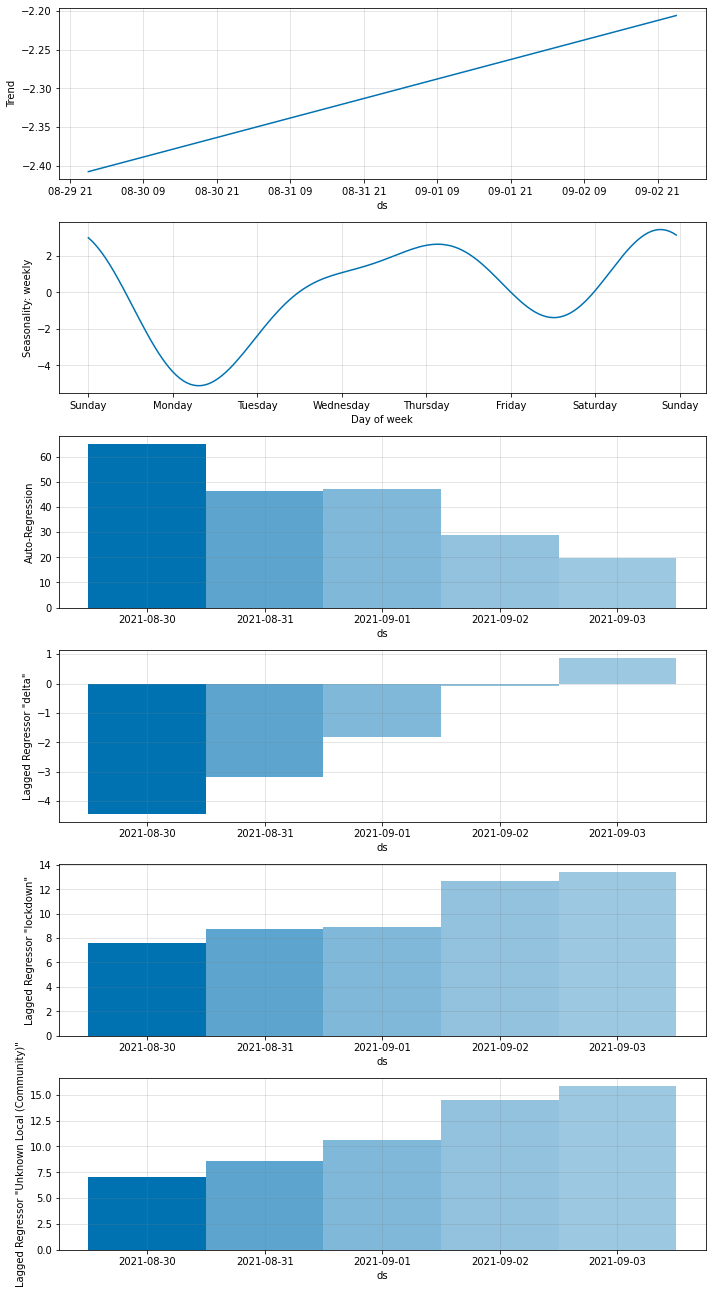

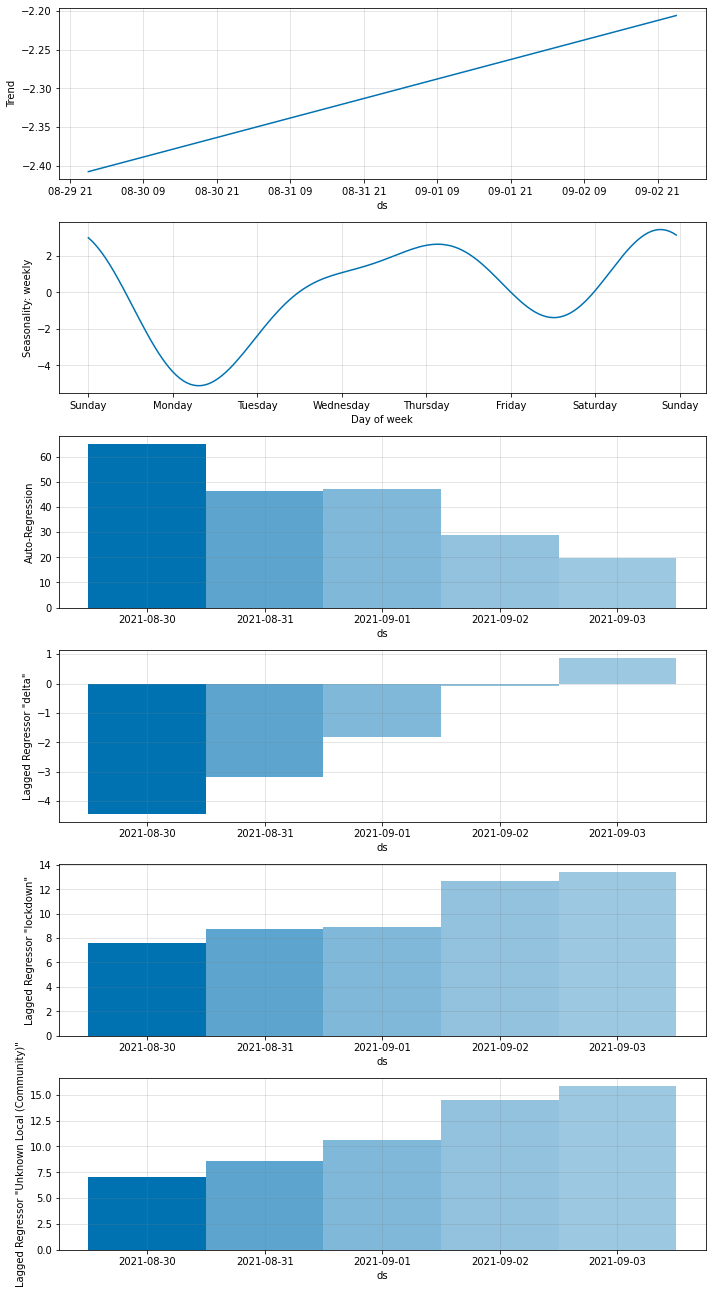

In [78]:
#Plotting the components
fb_neural_model.plot_components(fb_neural_forecast)

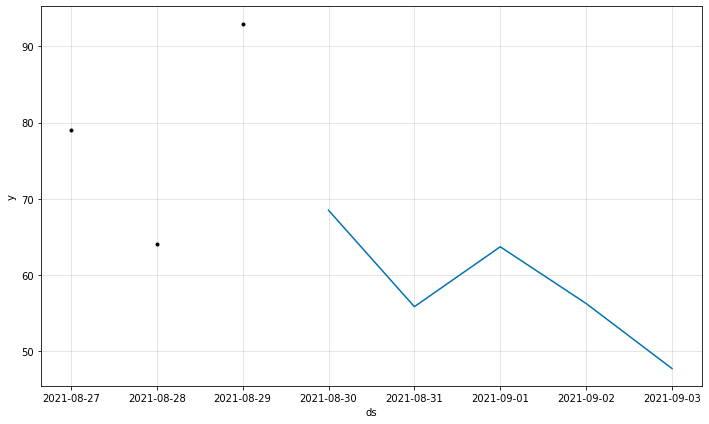

In [79]:
#Making the forecast plot
fb_neural_model.plot(fb_neural_forecast);

In [80]:
forecasts = []
for col in fb_neural_forecast.columns:
    if 'yhat' in col:
        forecasts.append([val for val in fb_neural_forecast[col] if val is not None][0])
forecast_df = fb_neural_forecast[["ds","y"]][-test.shape[0]:]
forecast_df.y = forecasts
forecast_df.set_index("ds", inplace=True)
forecast_df.head()

,y
ds,
2021-08-30,68.484718
2021-08-31,55.817116
2021-09-01,63.686073
2021-09-02,56.234352
2021-09-03,47.688961


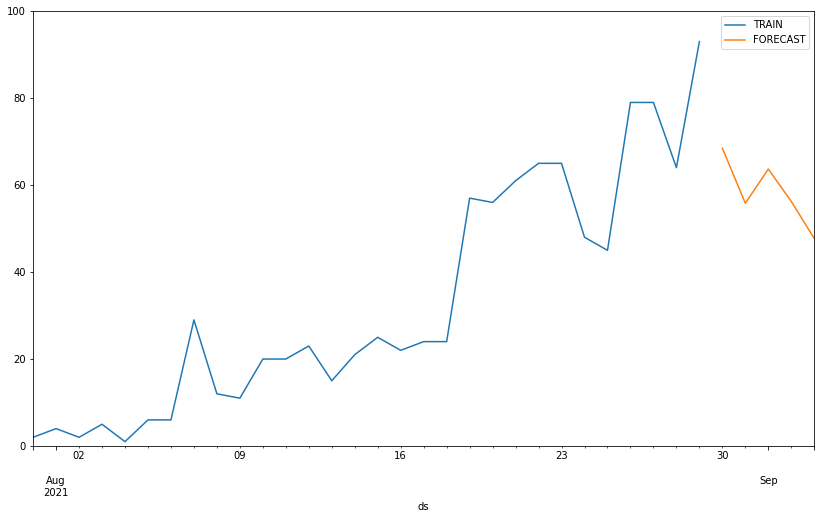

In [81]:
ax = vic_cases_wf_final["y"].plot(figsize=(14,8))
ax.plot(forecast_df["y"])
ax.set_xlim(date(2021,7,31), date(2021,9,3))
ax.set_ylim(0,100)
ax.legend(["TRAIN","FORECAST"]);

# 19 Are these any better than moving average models, why should we use or not use them? 